# ECON 409: Final Project
#### Courtney Manhart, Tanner Woods, Lindsay Mahowald, and Martin Jamouss

In [1]:
# Import Necessary Packages
import yfinance as yf 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import io
import matplotlib.lines as mlines
import statsmodels.formula.api as smf 
from statsmodels.tsa.arima.model import ARIMA
import scipy.stats as st
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess 
import pmdarima as pm 
from statsmodels.graphics.tsaplots import plot_predict

### Import the Data: Choose one or more series of economic fundamentals to use for generating exchange rate forecasts. The forecasts of the asset price may be directional or point forecasts

###### Economic Fundamentals of Interest: Interest Rate, Inflation, Unemployment (CHOOSE WHICH ONES TO USE)

In [14]:
# The following data includes:
    # US & UK interest rates
    # US & UK inflation rates
    # US & UK unemployment rates
    # Exchange Rate of the US dollar and British Pound

data = pd.read_csv('final_project_data.csv', index_col = 0, parse_dates = True)
data

,United States Interest,United Kingdom Interest,United States Inflation,United Kingdom Inflation,United States Unemployment,United Kingdom Unemployment,DEXUSUK
1983-02-01,8.54,11.3338,0.037076,0.049259,10.4,10.7,1.5115
1983-03-01,8.69,10.9757,0.034847,0.053428,10.4,10.8,1.4825
1983-04-01,8.63,10.2616,0.035903,0.046267,10.3,10.8,1.5573
1983-05-01,8.49,10.2593,0.040000,0.040038,10.2,11.0,1.6005
1983-06-01,9.20,9.9384,0.034411,0.036957,10.1,10.9,1.5330
...,...,...,...,...,...,...,...
2022-07-01,2.50,1.8400,0.089330,0.081688,3.6,3.6,1.2183
2022-08-01,2.76,2.2300,0.084132,0.087971,3.5,3.5,1.1647
2022-09-01,3.21,2.9100,0.082274,0.086530,3.7,3.6,1.1134
2022-10-01,3.85,3.3900,0.082149,0.088078,3.5,3.7,1.1515


In [15]:
# Import Risk-Free Rate from the treasurey yields
rf_rate = pd.read_csv('1-year-treasury-rate-yield-chart.csv', 
                       index_col = 0, parse_dates = True).ffill()
rf_rate.columns = ['rfr']

### The Risk-Free Rates are an annual rate based on the price 
### of the 1-year Treasure Bond on the given day. So to to get 
### Monthly risk-free rates we need to:
    ## i_m = [(1 + i_a) **(1/12)] - 1
# Note: We want Monthly since our data is monhtly

rf_rate = (((rf_rate / 100) + 1) ** (1/12)) - 1



# Adding the Risk-Free Rate to our DataFrame
data = pd.merge_asof(data, rf_rate, left_index = True, 
                     right_index = True)
data

,United States Interest,United Kingdom Interest,United States Inflation,United Kingdom Inflation,United States Unemployment,United Kingdom Unemployment,DEXUSUK,rfr
1983-02-01,8.54,11.3338,0.037076,0.049259,10.4,10.7,1.5115,0.007153
1983-03-01,8.69,10.9757,0.034847,0.053428,10.4,10.8,1.4825,0.006883
1983-04-01,8.63,10.2616,0.035903,0.046267,10.3,10.8,1.5573,0.007469
1983-05-01,8.49,10.2593,0.040000,0.040038,10.2,11.0,1.6005,0.007015
1983-06-01,9.20,9.9384,0.034411,0.036957,10.1,10.9,1.5330,0.007507
...,...,...,...,...,...,...,...,...
2022-07-01,2.50,1.8400,0.089330,0.081688,3.6,3.6,1.2183,0.002296
2022-08-01,2.76,2.2300,0.084132,0.087971,3.5,3.5,1.1647,0.002450
2022-09-01,3.21,2.9100,0.082274,0.086530,3.7,3.6,1.1134,0.002879
2022-10-01,3.85,3.3900,0.082149,0.088078,3.5,3.7,1.1515,0.003314


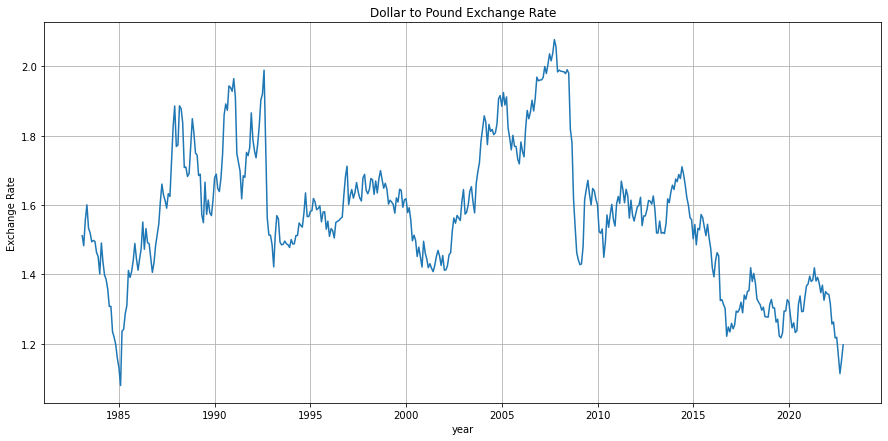

In [23]:
## Plot the Exchange Rate
plt.figure(figsize = (15, 7))
plt.plot(data['DEXUSUK'])
plt.title('Dollar to Pound Exchange Rate')
plt.ylabel('Exchange Rate')
plt.xlabel('year')
plt.grid()
plt.show()

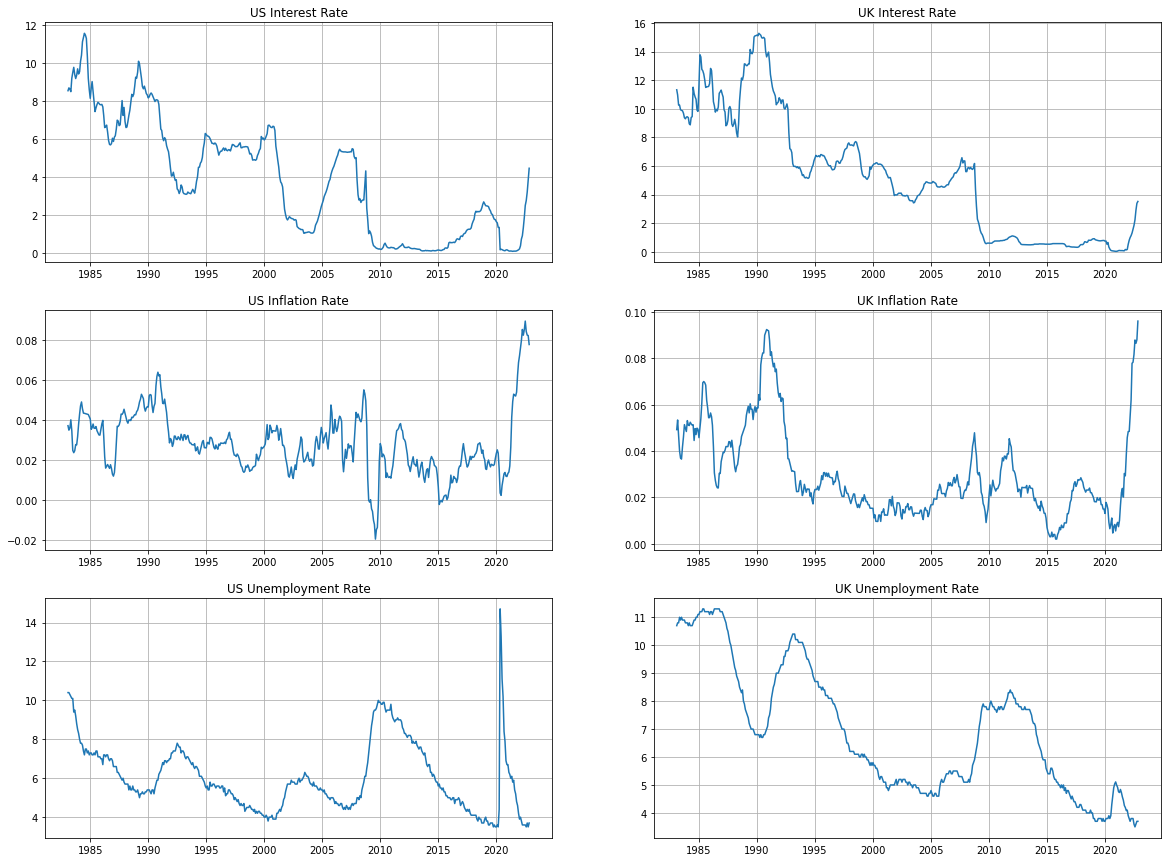

In [32]:
## Plotting the differences
fig, ax = plt.subplots(3, 2, figsize = (20, 15))

# Interest Rates
ax[0,0].plot(data['United States Interest'])
ax[0,0].set_title('US Interest Rate')
ax[0,0].grid()

ax[0,1].plot(data['United Kingdom Interest'])
ax[0,1].set_title('UK Interest Rate')
ax[0,1].grid()

# Inflation Rates
ax[1,0].plot(data['United States Inflation'])
ax[1,0].set_title('US Inflation Rate')
ax[1,0].grid()

ax[1,1].plot(data['United Kingdom Inflation'])
ax[1,1].set_title('UK Inflation Rate')
ax[1,1].grid()

# Unemployment Rates
ax[2,0].plot(data['United States Unemployment'])
ax[2,0].set_title('US Unemployment Rate')
ax[2,0].grid()

ax[2,1].plot(data['United Kingdom Unemployment'])
ax[2,1].set_title('UK Unemployment Rate')
ax[2,1].grid()

plt.show()

In [27]:
## Scale the Data:
    # We want the data to be comparable & on the same scale
def scale(X):
    num = X - X.min()
    denom = X.max() - X.min()
    return num/denom

scaled_data = pd.DataFrame(index = data.index)
scaled_data['US_ir'] = scale(data['United States Interest'])
scaled_data['UK_ir'] = scale(data['United Kingdom Interest'])


scaled_data['US_inf'] = scale(data['United States Inflation'])
scaled_data['UK_inf'] = scale(data['United Kingdom Inflation'])

scaled_data['US_unemp'] = scale(data['United States Unemployment'])
scaled_data['UK_unemp'] = scale(data['United Kingdom Unemployment'])

scaled_data['DEXUSUK'] = data['DEXUSUK']
scaled_data['rfr'] = data['rfr']
scaled_data

,US_ir,UK_ir,US_inf,UK_inf,US_unemp,UK_unemp,DEXUSUK,rfr
1983-02-01,0.736704,0.740946,0.520246,0.502131,0.616071,0.923077,1.5115,0.007153
1983-03-01,0.749782,0.717473,0.499777,0.546416,0.616071,0.935897,1.4825,0.006883
1983-04-01,0.744551,0.670665,0.509473,0.470334,0.607143,0.935897,1.5573,0.007469
1983-05-01,0.732345,0.670514,0.547090,0.404152,0.598214,0.961538,1.6005,0.007015
1983-06-01,0.794246,0.649480,0.495774,0.371417,0.589286,0.948718,1.5330,0.007507
...,...,...,...,...,...,...,...,...
2022-07-01,0.210113,0.118643,1.000000,0.846664,0.008929,0.012821,1.2183,0.002296
2022-08-01,0.232781,0.144207,0.952275,0.913424,0.000000,0.000000,1.1647,0.002450
2022-09-01,0.272014,0.188779,0.935215,0.898110,0.017857,0.012821,1.1134,0.002879
2022-10-01,0.327812,0.220243,0.934066,0.914561,0.000000,0.025641,1.1515,0.003314


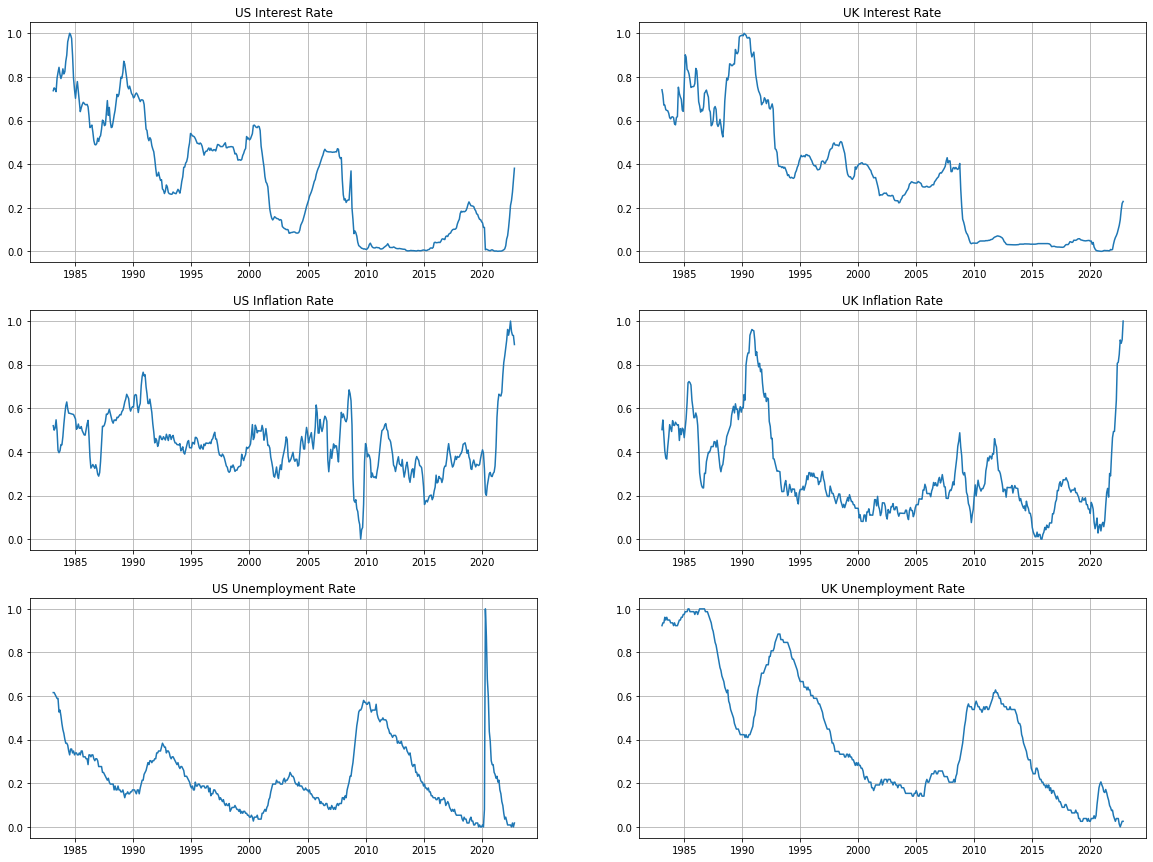

In [33]:
## Plotting the Scaled Data
fig, ax = plt.subplots(3, 2, figsize = (20, 15))

# Interest Rates
ax[0,0].plot(scaled_data['US_ir'])
ax[0,0].set_title('US Interest Rate')
ax[0,0].grid()

ax[0,1].plot(scaled_data['UK_ir'])
ax[0,1].set_title('UK Interest Rate')
ax[0,1].grid()

# Inflation Rates
ax[1,0].plot(scaled_data['US_inf'])
ax[1,0].set_title('US Inflation Rate')
ax[1,0].grid()

ax[1,1].plot(scaled_data['UK_inf'])
ax[1,1].set_title('UK Inflation Rate')
ax[1,1].grid()

# Unemployment Rates
ax[2,0].plot(scaled_data['US_unemp'])
ax[2,0].set_title('US Unemployment Rate')
ax[2,0].grid()

ax[2,1].plot(scaled_data['UK_unemp'])
ax[2,1].set_title('UK Unemployment Rate')
ax[2,1].grid()

plt.show()

In [29]:
## Calculating the Differentials using Scaled Data:
    # US - UK

diffs = pd.DataFrame(index = scaled_data.index)

# Interest Rate Differential
ir_diff = scaled_data['US_ir'] - scaled_data['UK_ir']
diffs['ir_diff'] = ir_diff

# Inflation Differential
inf_diff = scaled_data['US_inf'] - scaled_data['UK_inf']
diffs['inf_diff'] = inf_diff

# Unemploymet Differential
unemp_diff = scaled_data['US_unemp'] - scaled_data['UK_unemp']
diffs['unemp_diff'] = unemp_diff


diffs['USUK_current'] = scaled_data['DEXUSUK']
diffs['USUK_future'] = scaled_data['DEXUSUK'].shift()  
diffs['USUK_change'] = diffs['USUK_future'] - diffs['USUK_current']
diffs['rfr'] = scaled_data['rfr']

diffs

,ir_diff,inf_diff,unemp_diff,USUK_current,USUK_future,USUK_change,rfr
1983-02-01,-0.004242,0.018115,-0.307005,1.5115,NaN,NaN,0.007153
1983-03-01,0.032309,-0.046639,-0.319826,1.4825,1.5115,0.0290,0.006883
1983-04-01,0.073886,0.039138,-0.328755,1.5573,1.4825,-0.0748,0.007469
1983-05-01,0.061831,0.142938,-0.363324,1.6005,1.5573,-0.0432,0.007015
1983-06-01,0.144766,0.124357,-0.359432,1.5330,1.6005,0.0675,0.007507
...,...,...,...,...,...,...,...
2022-07-01,0.091471,0.153336,-0.003892,1.2183,1.2162,-0.0021,0.002296
2022-08-01,0.088575,0.038851,0.000000,1.1647,1.2183,0.0536,0.002450
2022-09-01,0.083235,0.037104,0.005037,1.1134,1.1647,0.0513,0.002879
2022-10-01,0.107569,0.019505,-0.025641,1.1515,1.1134,-0.0381,0.003314


### Outline Trading Rules based on these forecasts:
- Long/short positions
- exiting positions

In [ ]:
## Taylor Rule - Generating the change in exchange rates 



In [ ]:
### Long / Short Postions:
    # Long:
    # Short: 


    
    
    
# Exiting Positions:


### Optimize at least 2 strategy Hyperparameters:
- length of holding period
- model hyperparameters (alpha for lasso, number of lags to include, rolling window size, etc)

In [ ]:
# specify candidate values for hyperparameters
ks = np.linspace(0.1, .99, 10)
zs = np.linspace(0.1, 3, 7)
ws = np.arange(7, 100, 7)
hs = np.arange(1, 100, 7)

import itertools as it
# build a grid with all possible hyperparameters
grid = np.array(np.meshgrid(ks,zs, ws)).T.reshape(-1,3)

grid

In [ ]:
storage = pd.DataFrame(columns = ["k", "z", "w", "h", "profits"])

# Loop through all grid values to find optimal 




In [ ]:
# Sorting the Storage DataFrame 
storage = storage.sort_values(by = "profits").reset_index(drop = True)
storage

### Visualize Optimization process using a heatmap

In [4]:
# Heatmaps

def heatmap(x, y, metric, values):
    
    # specify the columns I will be pulling from the results
    p2p = values[[x, y, metric]]
    
    # If p > 2, we need to group 
    heat = np.round(p2p.groupby([x,y]).max(),1)
    heat = heat.unstack()[metric]

    # round labels
    heat.index = np.round(heat.index,2)
    heat.columns = np.round(heat.columns,2)

    # make plot
    f, ax = plt.subplots(figsize=(15, 8))
    ax = sns.heatmap(heat, fmt='.1g')
    ax.set_title("Heat map of "+ metric,size = 15)
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.set_xlabel(y, size = 15)
    ax.set_ylabel(x, size = 15)
    ax.collections[0].colorbar.set_label(metric, size = 15)
    sns.set(font_scale=1)
    plt.show()

In [ ]:
# Heatmap for Hyperparameters
heatmap()

### Trading Strategy: using the optimal results

In [ ]:
# According to the tables, the set of hyper-parameters that
    # produce the largest profits are:
print(blue('Final Hyper-Parameters:', ['bold']))
k, z, w, h, p = storage.iloc[-1]
print('k:', k)
print('z:', z)
print('w:', w)
print('h:', h)
print('Profits:', p)

In [ ]:
## Implementing the Strategy with the Optimal Results 

strategy = 

### Produce Equity Curve over a backtest

In [ ]:
# Visulizing the Exchange Rate, the Kalman CI, Long & Short Positions



In [ ]:
### Plotting the Trading Positions 



In [ ]:
## Plotting the Equity Curve
plt.figure(figsize = (15, 5))
sns.set_style("white")
(strategy["cumulative_returns"]).plot()

plt.title("Price Earnings Strategy:"+ ", Z = "
          +str(z) + ", w = " + str(w)+ ", k = " + str(k))



plt.legend(["Equity Curve"])

plt.grid()

### Use the Binomial Test (directional forecast) or the DMW Test (point forecast) 

### Produce table with HFRI Metrics to evaluare the strategy's performance

#### Setting up the Tables:

In [ ]:
## Risk/Return Table
index = ['Geo. Average Monthly', 'Std. Deviation', 'High Month',
        'Low Month', 'Annualized Return', 'Annualized STD', 
        'Risk Free Rate', 'Sharpe Ratio', '% of Winning Mo.',
        'Max Drawdown']
columns = ['Strategy']
risk_return_table = pd.DataFrame(index = index, columns = columns)

In [ ]:
## Regresssion Table:
index = ['Alpha', 'Beta', 'Mnt. R-Squared', 'Correlation', 
         'Up Alpha', 'Up Beta', 'Up R-Squared', 'Down Alpha',
        'Down Beta', 'Down R-Squared']
columns = ['Strategy']
reg_table = pd.DataFrame(index = index, columns = columns)

#### Regression Results -- Use Monthly returns except for Sharpe Ratio (use annual returns)

In [30]:
## Downloading Market Rate & risk-free rate
    # Market Rate: S&P 500 (from yfinance)
    # Risk-Free Rate: 1-year treasury rates (using csv from class)

# Market
market = yf.download('^GSPC')
market = market['Adj Close']


# Risk-Free Rate

rf_rate

[*********************100%***********************]  1 of 1 completed


,rfr
date,
1962-01-02,0.002645
1962-01-03,0.002661
1962-01-04,0.002661
1962-01-05,0.002677
1962-01-08,0.002717
...,...
2023-01-08,0.003787
2023-01-09,0.003787
2023-01-10,0.003787


*Alpha & Beta*

In [ ]:
# Calculating Excess Returns
    # Strategy Excess Returns: Strategy - Risk Free Rate
    # Market Excess Returns: Market - Risk Free Rate

ex_return = pd.DataFrame(index = strategy.index)    
ex_return['Returns'] = stragety['Returns'] - strategy['rfr']
ex_return['Market'] = stragety['Market'] - strategy['rfr']

# Run an OLS Regression: Strategy Excess Returns ~ Market Excess Returns 
ols = smf.ols('Returns ~ Market', data = ex_return).fit()
ols.summary()

In [ ]:
### Determining Alpha & Beta
alpha = ols.params[0] # Intercept
beta = ols.params[1] # Slope

# Adding Alpha & Beta to the DataFrame
reg_table.at['Alpha', 'Strategy'] = alpha
reg_table.at['Beta', 'Strategy'] = beta

*Mnt. R-Squared*

In [ ]:
# Getting R-Squared from the above Regression
r_sq = ols.rsquared

# Adding R-Squared to the DataFrame
reg_table.at['Mnt. R-Squared', 'Strategy'] = r_sq

*Correlation*

In [ ]:
reg_table.at['Correlation', 'Strategy'] = corr

*Up Alpha, Up Beta & Up R-Squared* <br>
- Up: When the S&P 500 yielded a higher than 0% return

In [ ]:
# Subset the data to only positive returns in the S&P 500
updf = ex_returns[ex_returns.Market > 0]

# Run the Regression
ols_up = smf.ols('Returns ~ Market', data = updf).fit()
ols_up.summary()

In [ ]:
## Determining Up Alpha, Up Beta, and Up R-Squared
up_alpha = ols_up.params[0]  # Intercept
up_beta = ols_up.params[1]   # Slope Coefficient
up_r_sq = ols_up.rsquared

# Adding Up Alpha, Up Beta, and Up R-Squared to the DataFrame
reg_table.at['Up Alpha', 'Strategy'] = up_alpha
reg_table.at['Up Beta', 'Strategy'] = up_beta
reg_table.at['Up R-Squared', 'Strategy'] = up_r_sq

*Down Alpha, Down Beta & Down R-Squared*
- Down: When the S&P 500 yielded a lower than 0% Return

In [ ]:
# Subset the data to only negative returns in the S&P 500
downdf = ex_returns[ex_returns.Market < 0]

# Run the Regression
ols_down = smf.ols('Returns ~ Market', data = downdf).fit()
ols_down.summary()

In [ ]:
## Determining Down Alpha, Down Beta, and Down R-Squared
down_alpha = ols_down.params[0]  # Intercept
down_beta = ols_down.params[1]   # Slope Coefficient
down_r_sq = ols_down.rsquared

# Adding Down Alpha, Down Beta, and Down R-Squared to the DataFrame
reg_table.at['Down Alpha', 'Strategy'] = down_alpha
reg_table.at['Down Beta', 'Strategy'] = down_beta
reg_table.at['Down R-Squared', 'Strategy'] = dow_r_sq

#### Risk/Return Results

*Geometric Average Monthly & Standard Deviation*

In [ ]:
# Calculating the Geometric Average
n = len(returns)
geo_avg = ((returns + 1).prod() ** (1/n)) - 1

# Calculating the Standard Deviation of the Returns
stdev = returns.std()

In [ ]:
risk_retun_table.at['Geo. Average Monthly', 'Strategy'] = geo_avg
risk_retun_table.at['Std. Deviation', 'Strategy'] = stdev

*High Month & Low Month*

In [ ]:
risk_retun_table.at['High Month', 'Strategy'] = high_month
risk_retun_table.at['Low Month', 'Strategy'] = low_month

*Annualized Return & Standard Deviation*

In [ ]:
## Calculating Annualized Returns

# Cumulative Return
end_value = (strategy['cumulative_retruns'] + 1)[-1]

# Number of Years Invested
t = len(strategy) # Number of months observed in the strategy
T = t / 12 # There are 12 months in a year

ann_return = ((end_value ** (1/T)) - 1) * 100


# Calculating the Annualized Standard Deviation


In [ ]:
risk_retun_table.at['Annualized Return', 'Strategy'] = ann_ret
risk_retun_table.at['Annualzed STD', 'Strategy'] = ann_std

*Risk Free Rate*

In [ ]:
## Based on the 1-year treasury bond for each year we are invested in a portfolio
rf_rate = ((rf_rate+1).resample('Y').prod() ** (1/12) - 1)

Y = len(strategy)/ 12 # number of months observed / 12 months in a year

rfr = (((rf_rate + 1).prod() ** (1/Y)) - 1) * 100

In [ ]:
risk_retun_table.at['Risk Free Rate', 'Strategy'] = rfr

*Sharpre Ratio*

In [ ]:
# Sharpe Ratio Definition
def sharpe_ratio(returns, rfr):
    excess_returns = returns - rfr
    
    SR = excess_returns.mean() / excess_returns.std()
    
    return SR

In [ ]:
# Calculating the Sharpe Ratio
returns = strategy['returns']
rfr = strategy['rfr']

sharpe_ratio = sharpe_ratio(returns, rfr)

# Add Sharpe Ratio to the Table
risk_retun_table.at['Sharpe Ratio', 'Strategy'] = sharpe_ratio

*% of Winning Mo.*

In [ ]:

# Add % Win to Table
risk_retun_table.at['% of Winning Mo.', 'Strategy'] = win_mo

*Max Drawdown*

In [ ]:

# Add Max Drawdown to Table 
risk_retun_table.at['Max Drawdown', 'Strategy'] = max_draw

#### Final Tables

In [ ]:
risk_return_table

In [ ]:
reg_table